# Prediction on Cancer Cells

For this machine learning project we were tasked to teach a binary classifier to identify if a given cancer cell could survive in a low oxygen environment (i.e. hypoxia) or if the cell needs oxygen to prosper (i.e. normoxia). We used data from an experiment which sequenced RNA from various breast cancer cells. Some cells came from a cell line that was in a low oxygen environment (~1%) and the other cells came from a cell line that was exposed to normal levels of oxygen. The aim for our binary classifier is to identify which genes (found in the RNA) can be attributed to the ability to survive in a low oxygen environment. Intuitively, if a gene were very present in cell from the hypoxia batch and not very present in the normal batch this could possibly mean that this gene helps cancer cells to survive even with very limited oxygen. From a medical point of view, this could help determine whether a certain cancer cell would need to be near arteries or if it could multiply even without a direct source of oxygen.

1. [Exploratory Data Analysis](#exploratory-data-analysis)
2. [Dimensionality Reduction](#dimensionality-reduction)
3. [Clustering](#clustering)
4. [Logistic Regression](#logistic-regression)
5. [Support Vector Machines](#support-vector-machines)
6. [Random Forest](#random-forest)
7. [Multi-Layer Perceptron](#mlp)
8. [Results](#results)

We were given data derived utilizing Smart-Seq as a sequencing technique. The cell types included in the datasets were MCF7 and HCC1608. As features, we have various genes what were found when sequencing RNA from the various cells.

In [5]:
#Importing libraries
from Utils.data_analysis import *
from Utils.processing import *
from Utils.dim_reduction import *
from Utils.modeling import *

from sklearn.model_selection import train_test_split
import warnings, csv
warnings.simplefilter("ignore")
%matplotlib inline     
sns.set_theme(color_codes=True)

---
## Exploratory Data Analysis

The first step of our analysis is the extraction of the data we were given, in order to visualize it and clean it, comparing our cleaning results with the pre-cleaned ones.   

### Imports

First we look at the metadeta datasets, which give us generic information about the cells, such as their names and experiment, under what conditions they were analysed under and for how many hours, as well as others. These statistics are some general observations to help us understand these datasets better.

In [2]:
df_meta_HCC = pd.read_csv("Data/raw_data/HCC1806_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
df_meta_MCF = pd.read_csv("Data/raw_data/MCF7_SmartS_MetaData.tsv",delimiter="\t",engine='python',index_col=0)
print("Meta data dimensions for HCC1806:", df_meta_HCC.shape)
print("Meta data dimensions for MCF7:", df_meta_MCF.shape)

df_meta_HCC.head()

Meta data dimensions for HCC1806: (243, 8)
Meta data dimensions for MCF7: (383, 8)


Cell Line  PCR Plate  Pos  \
Filename                                                                       
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....   HCC1806          1  A10   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...   HCC1806          1  A12   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...   HCC1806          1   A1   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...   HCC1806          1   A2   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...   HCC1806          1   A3   

                                                   Condition  Hours Cell name  \
Filename                                                                        
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....     Normo     24      S123   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...     Normo     24       S26   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...      Hypo     24       S97   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...      Hypo     24      S104   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...      Hypo     24        S4   

                                                                 PreprocessingTag  \
Filename                                                                            
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  Aligned.sortedByCoord.out.bam   
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  Aligned.sortedByCoord.out.bam   

                                                    ProcessingComments  
Filename                                                                
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned....  STAR,FeatureCounts  
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.s...  STAR,FeatureCounts  
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sor...  STAR,FeatureCounts  
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.so...  STAR,FeatureCounts  
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sort...  STAR,FeatureCounts

We can now move to the more interesting and useful datasets. These are the unfiltered datasets in which we are given the crude experimental data. We will explore them and clean them up a bit before using them to train the models.

In [3]:
#HCC cell line
df_HCC_s_f = pd.read_csv("Data/raw_data/HCC1806_SmartS_Filtered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_HCC_model = pd.read_csv("Data/raw_data/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_HCC_s_uf = pd.read_csv("Data/raw_data/HCC1806_SmartS_Unfiltered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
print("Number of genes for unfiltered HCC1806 data: ", df_HCC_s_uf.shape[0])
print("Number of cells for unfiltered HCC1806 data: ", df_HCC_s_uf.shape[1])

#MCF cell line
df_MCF_s_f = pd.read_csv("Data/raw_data/MCF7_SmartS_Filtered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_MCF_model = pd.read_csv("Data/raw_data/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
df_MCF_s_uf = pd.read_csv("Data/raw_data/MCF7_SmartS_Unfiltered_Data.txt", delimiter="\ ",engine='python',index_col=0, quoting=csv.QUOTE_NONE)
print("Number of genes for unfiltered MCF7 data: ", df_MCF_s_uf.shape[0])
print("Number of cells for unfiltered MCF7 data: ", df_MCF_s_uf.shape[1])

Number of genes for unfiltered HCC1806 data:  23396
Number of cells for unfiltered HCC1806 data:  243
Number of genes for unfiltered MCF7 data:  22934
Number of cells for unfiltered MCF7 data:  383


### Unfiltered Data Analysis

We now look at the distribution of genes in the unfiltered data, through the use of histograms due to the large amount of genes we are analyzing:

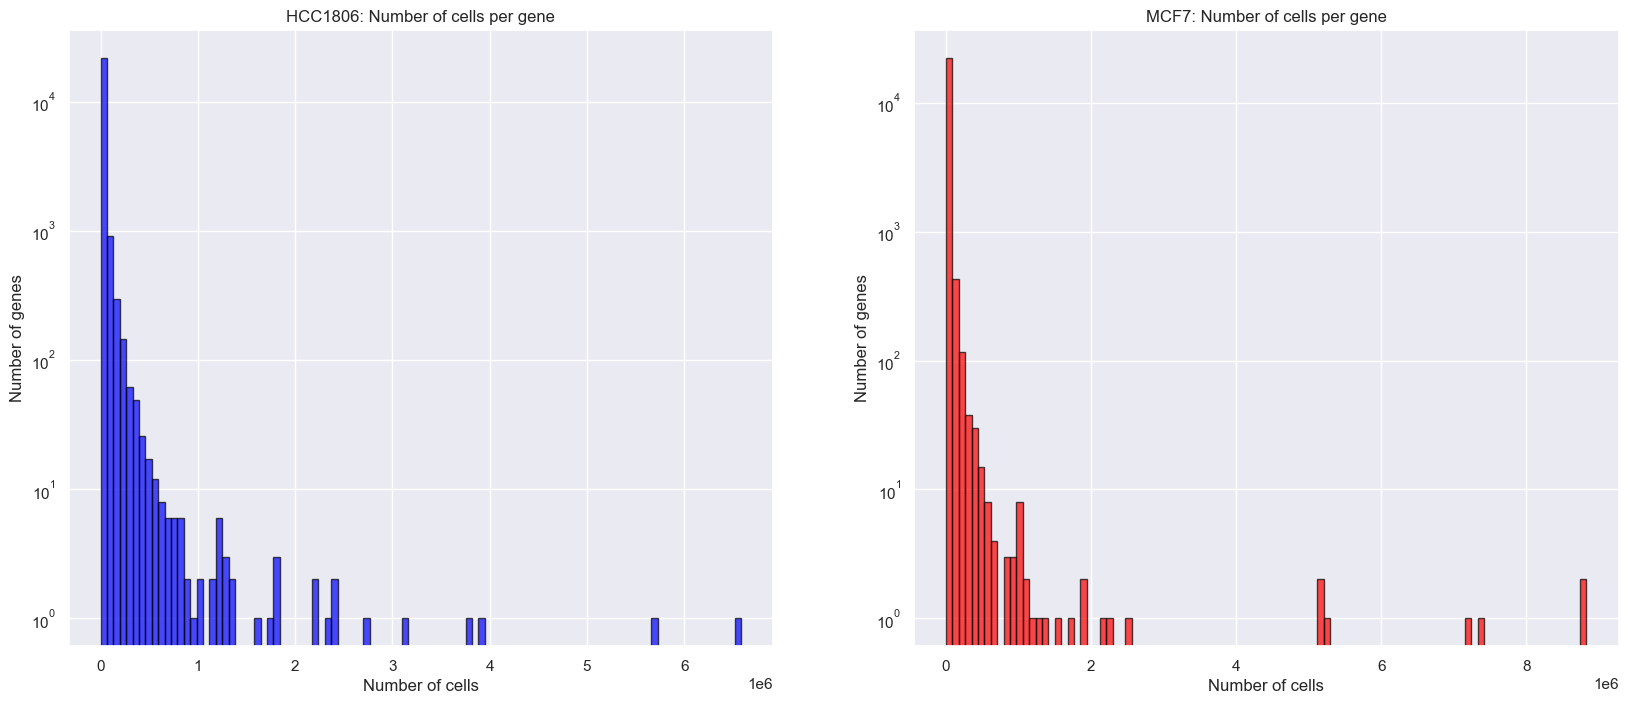

In [4]:
# Histogram plot with average gene expression per gene
plot_gene_expression(df_HCC_s_uf, df_MCF_s_uf)

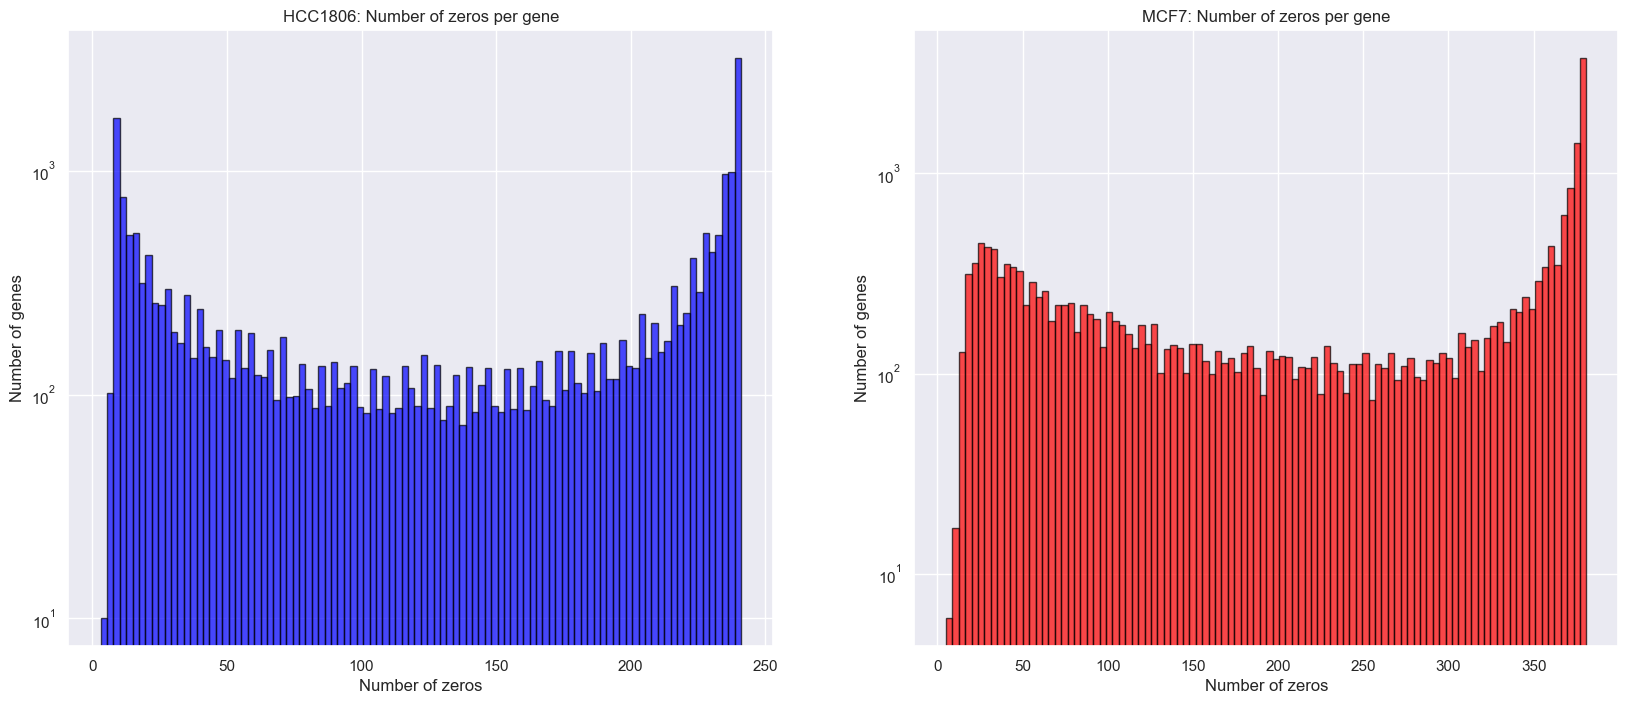

In [5]:
# How many zeros entries for each gene in the unfiltered data
plot_zeros(df_HCC_s_uf, df_MCF_s_uf)

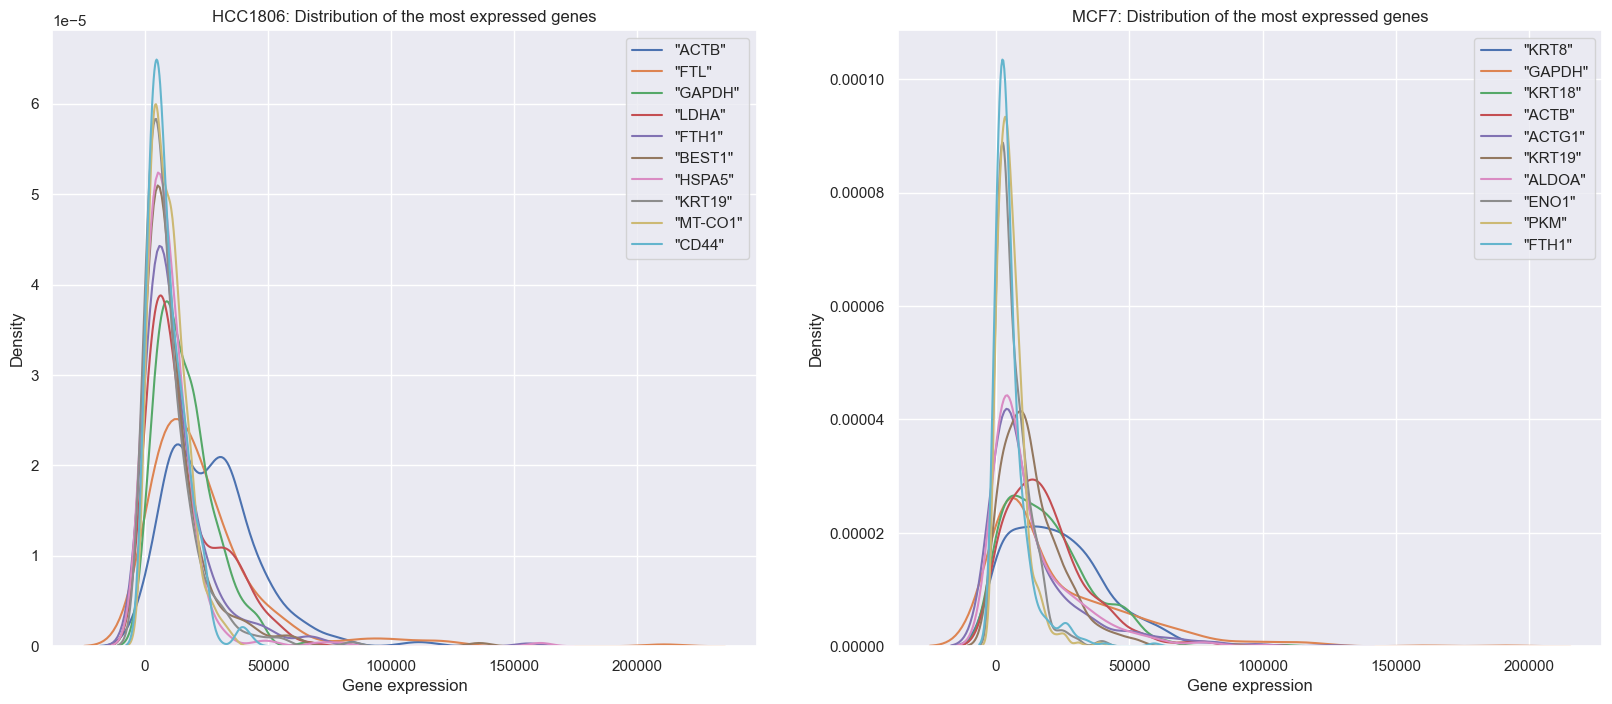

In [6]:
# Plot the distribution of the most expressed genes
plot_top_genes(df_HCC_s_uf, df_MCF_s_uf)

In [7]:
df_HCC_hypo, df_HCC_norm = split_hypo_norm(df_HCC_s_uf.T)
df_MCF_hypo, df_MCF_norm = split_hypo_norm(df_MCF_s_uf.T)

#How many hypoxia and how many normoxia are in each dataset
print("Number of hypoxia cells for HCC1806 data: ", len(df_HCC_hypo)) 
print("Number of normoxia cells for HCC1806 data: ", len(df_HCC_norm))

print("Number of hypoxia cells for MCF7 data: ", len(df_MCF_hypo)) 
print("Number of normoxia cells for MCF7 data: ", len(df_MCF_norm))

Number of hypoxia cells for HCC1806 data:  126
Number of normoxia cells for HCC1806 data:  117
Number of hypoxia cells for MCF7 data:  191
Number of normoxia cells for MCF7 data:  192


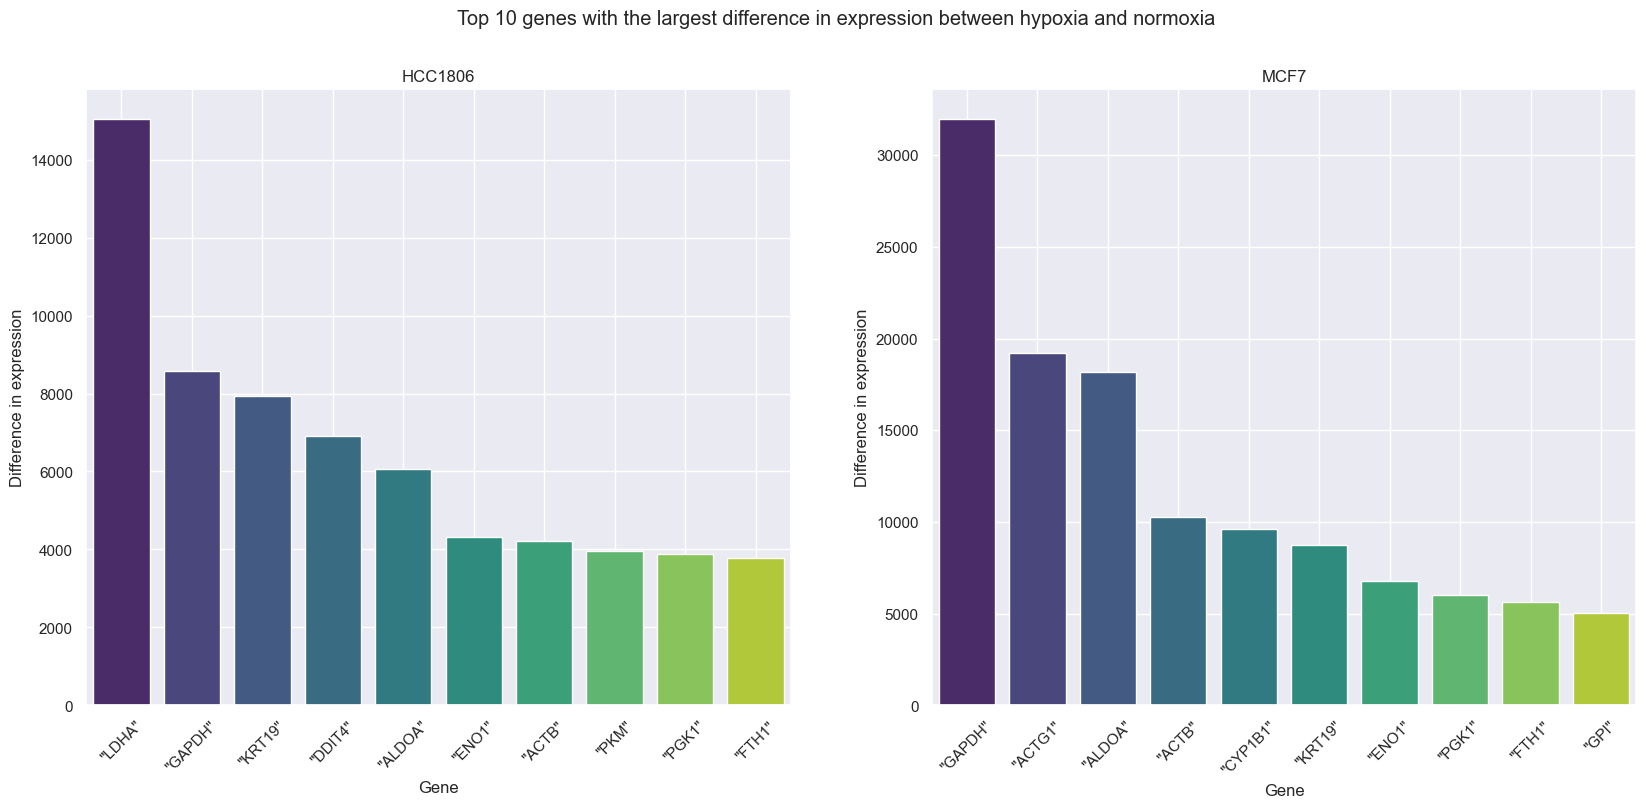

In [8]:
# Which genes have the largest difference in expression between hypoxia and normoxia
plot_diff_genes(df_HCC_s_uf, df_MCF_s_uf)

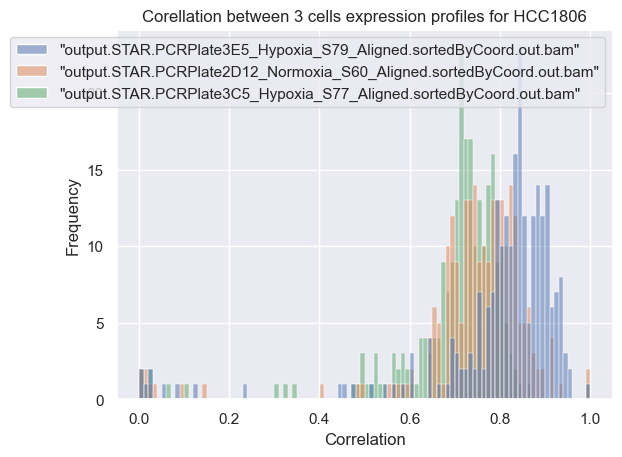

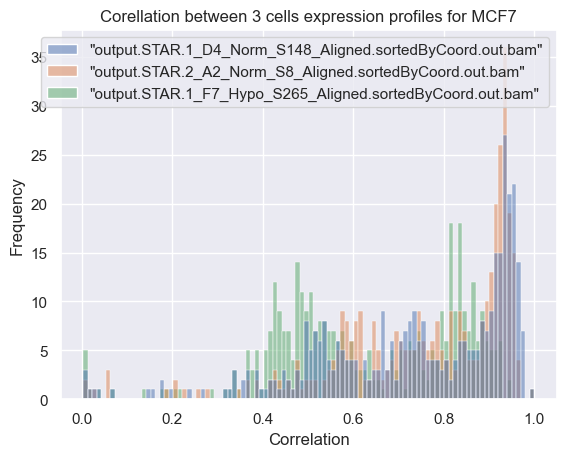

In [9]:
hist_cor(df_HCC_s_uf, title="HCC1806")
hist_cor(df_MCF_s_uf, title="MCF7")

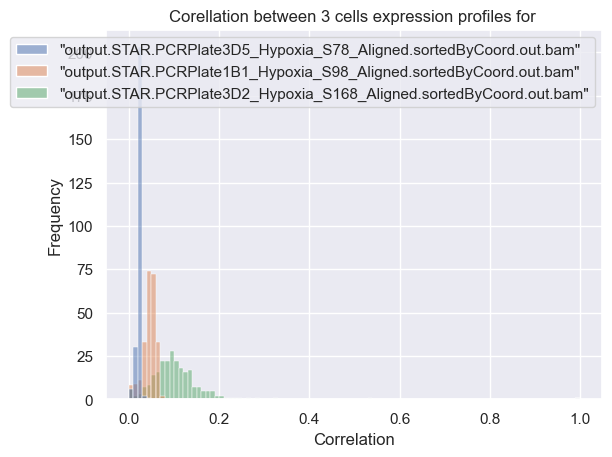

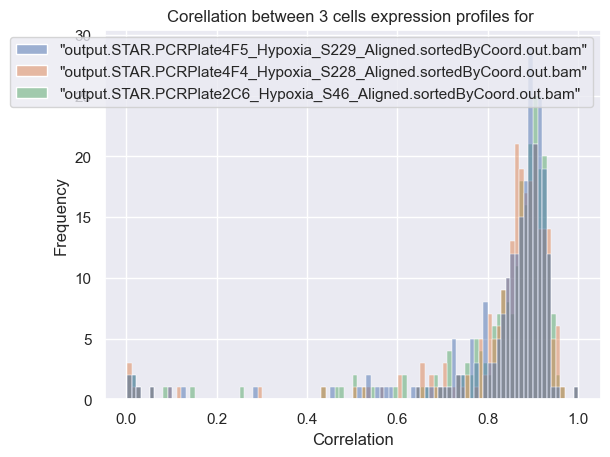

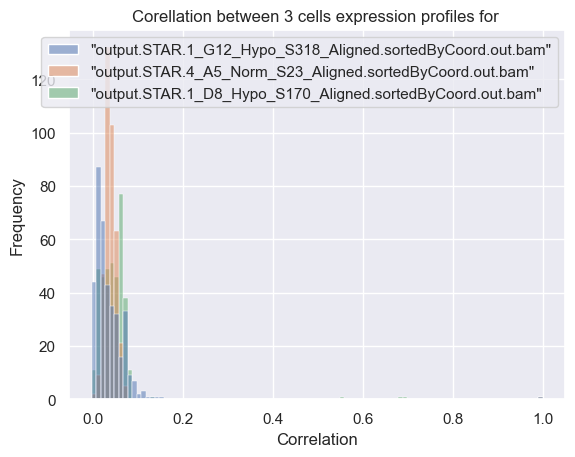

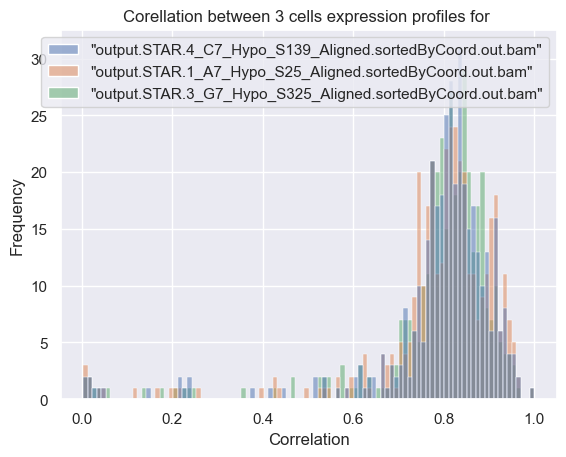

In [10]:
hist_cor(df_HCC_s_uf, cells=smallest_correlation(df_HCC_s_uf)[4:7])
hist_cor(df_HCC_s_uf, cells=largest_correlation(df_HCC_s_uf))

hist_cor(df_MCF_s_uf, cells=smallest_correlation(df_MCF_s_uf)[4:7])
hist_cor(df_MCF_s_uf, cells=largest_correlation(df_MCF_s_uf))

In [11]:
print("Fraction of zeros in HCC1806 unfiltered data: ", frac_zeros(df_HCC_s_uf))
print("Fraction of zeros in Small Correlation HCC1806 data: ", frac_zeros(df_HCC_s_uf[smallest_correlation(df_HCC_s_uf)]))
print("Fraction of zeros in Large Correlation HCC1806 data: ", frac_zeros(df_HCC_s_uf[largest_correlation(df_HCC_s_uf)]))

print("Fraction of zeros in MCF7 unfiltered data: ", frac_zeros(df_MCF_s_uf))
print("Fraction of zeros in Small Correlation MCF7 data: ", frac_zeros(df_MCF_s_uf[smallest_correlation(df_MCF_s_uf)]))
print("Fraction of zeros in Large Correlation MCF7 data: ", frac_zeros(df_MCF_s_uf[largest_correlation(df_MCF_s_uf)]))

Fraction of zeros in HCC1806 unfiltered data:  55.85
Fraction of zeros in Small Correlation HCC1806 data:  95.11
Fraction of zeros in Large Correlation HCC1806 data:  52.33
Fraction of zeros in MCF7 unfiltered data:  60.22
Fraction of zeros in Small Correlation MCF7 data:  96.51
Fraction of zeros in Large Correlation MCF7 data:  60.84


The cells with low correlation present a much higher percentage of zeros compared to the rest of the dataset!!

### Data Cleaning

In [12]:
# Count missing values in data
print("Number of missing values in HCC1806 unfiltered data: ", df_HCC_s_uf.isnull().sum().sum())
print("Number of missing values in MCF7 unfiltered data: ", df_MCF_s_uf.isnull().sum().sum())

# Check for duplicated genes
print("Number of duplicated genes in HCC1806 unfiltered data: ", df_HCC_s_uf.index.duplicated().sum())
print("Number of duplicated genes in MCF7 unfiltered data: ", df_MCF_s_uf.index.duplicated().sum())

# Check for duplicated cells
print("Number of duplicated cells in HCC1806 unfiltered data: ", df_HCC_s_uf.columns.duplicated().sum())
print("Number of duplicated cells in MCF7 unfiltered data: ", df_MCF_s_uf.columns.duplicated().sum())

Number of missing values in HCC1806 unfiltered data:  0
Number of missing values in MCF7 unfiltered data:  0
Number of duplicated genes in HCC1806 unfiltered data:  0
Number of duplicated genes in MCF7 unfiltered data:  0
Number of duplicated cells in HCC1806 unfiltered data:  0
Number of duplicated cells in MCF7 unfiltered data:  0


Number of genes with same expression in HCC1806 unfiltered data:  54
Number of genes with same expression in MCF7 unfiltered data:  29


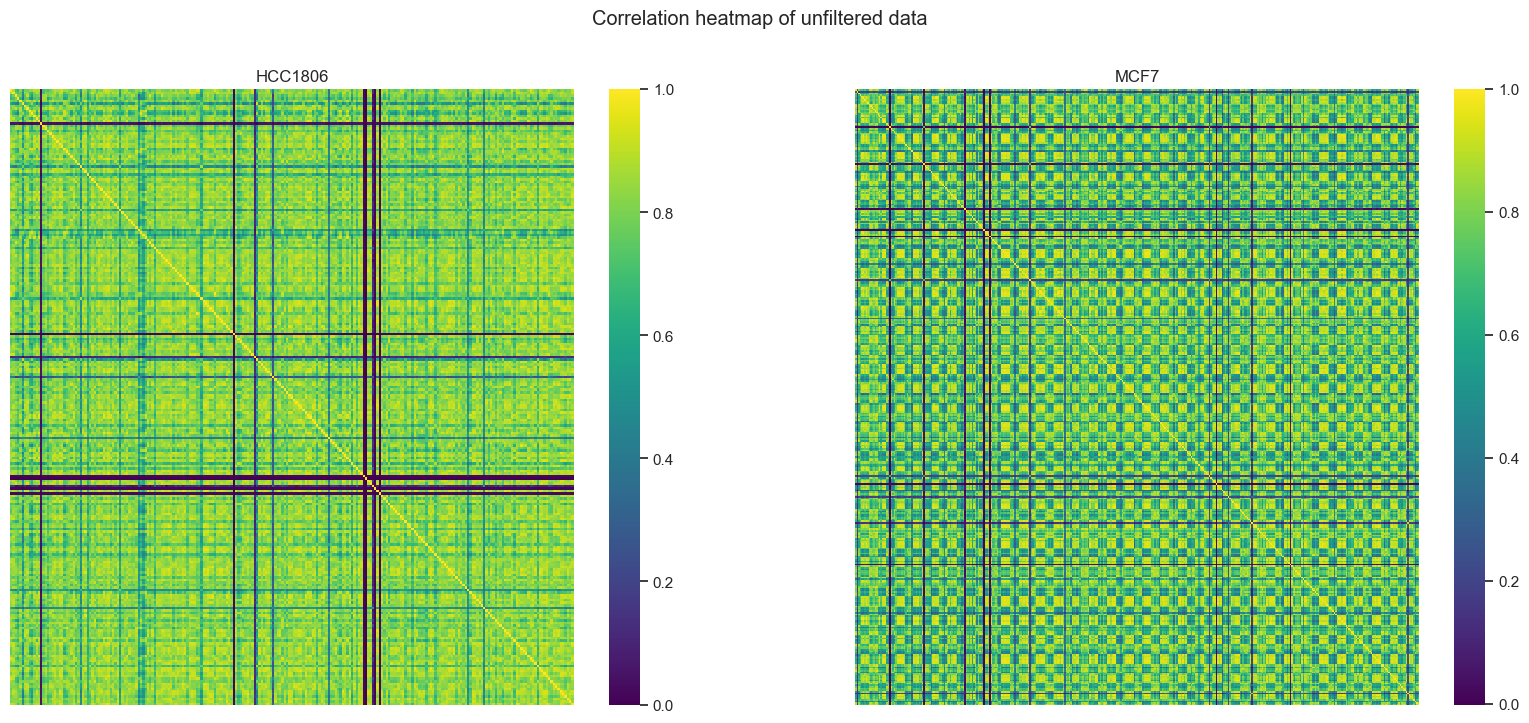

In [13]:
# Check for genes with same expression
print("Number of genes with same expression in HCC1806 unfiltered data: ", df_HCC_s_uf.duplicated().sum())
print("Number of genes with same expression in MCF7 unfiltered data: ", df_MCF_s_uf.duplicated().sum())

correlation_heatmap(df_HCC_s_uf, df_MCF_s_uf)

In [14]:
# Drop duplicated genes
print("Number of genes in HCC1806 unfiltered data before dropping duplicates: ", df_HCC_s_uf.shape[0])
print("Number of genes in MCF7 unfiltered data before dropping duplicates: ", df_MCF_s_uf.shape[0])
df_HCC_s_uf = df_HCC_s_uf[~df_HCC_s_uf.duplicated(keep='first')]
df_MCF_s_uf = df_MCF_s_uf[~df_MCF_s_uf.duplicated(keep='first')]
print("Number of genes in HCC1806 unfiltered data after dropping duplicates: ", df_HCC_s_uf.shape[0])
print("Number of genes in MCF7 unfiltered data after dropping duplicates: ", df_MCF_s_uf.shape[0])

Number of genes in HCC1806 unfiltered data before dropping duplicates:  23396
Number of genes in MCF7 unfiltered data before dropping duplicates:  22934
Number of genes in HCC1806 unfiltered data after dropping duplicates:  23342
Number of genes in MCF7 unfiltered data after dropping duplicates:  22905


### Rescale and Normalize

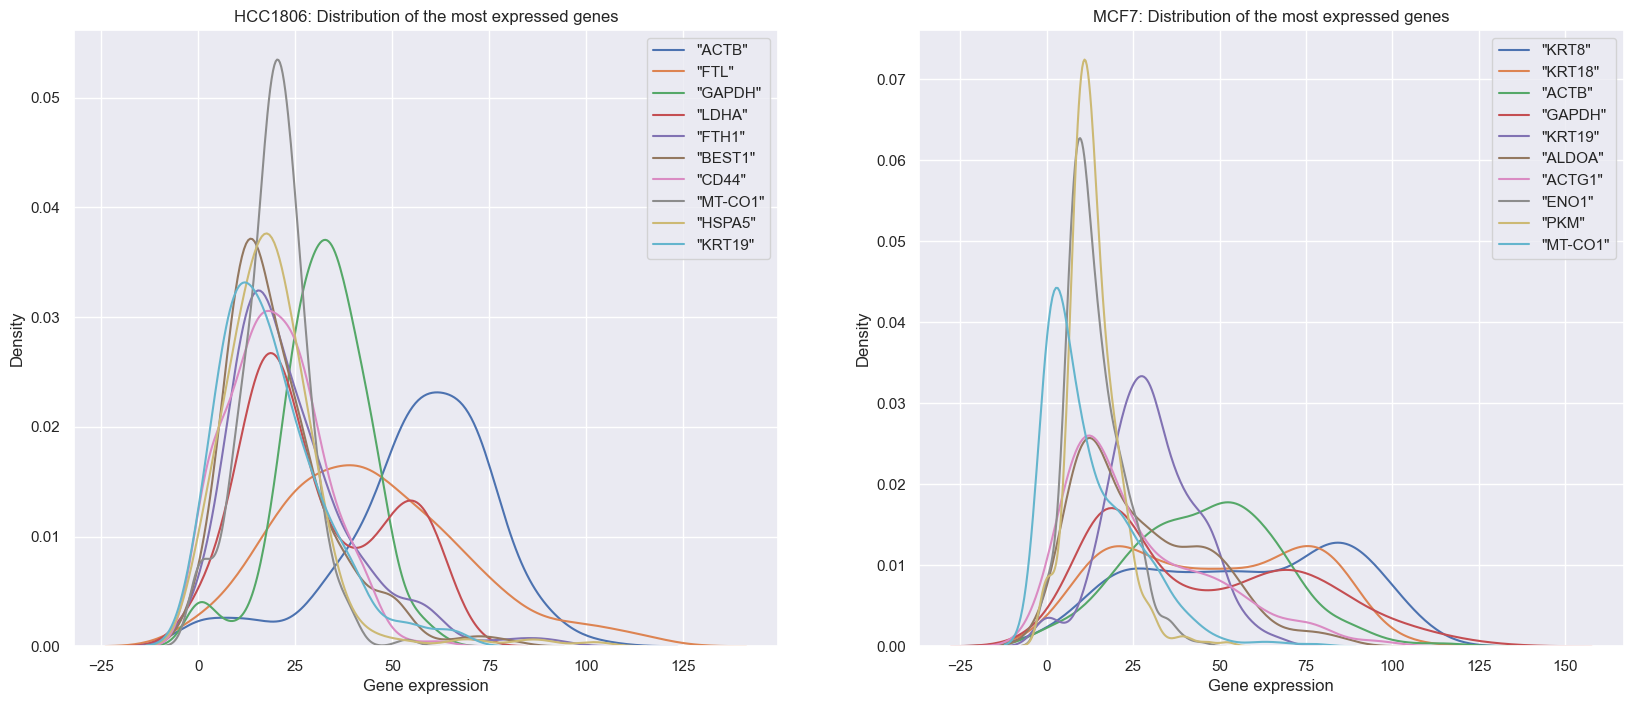

In [15]:
# Rescale and normalize the data
df_HCC_s_uf_rescaled = rescale_normalize(df_HCC_s_uf)
df_MCF_s_uf_rescaled = rescale_normalize(df_MCF_s_uf)

plot_top_genes(df_HCC_s_uf_rescaled, df_MCF_s_uf_rescaled)

### Train-Test Split

In [16]:
# Delete DataFrames to free memory
del df_HCC_s_f, df_HCC_s_uf, df_MCF_s_f, df_MCF_s_uf, df_meta_HCC, df_meta_MCF, df_HCC_hypo, df_HCC_norm, df_MCF_hypo, df_MCF_norm, df_HCC_s_uf_rescaled, df_MCF_s_uf_rescaled

In [17]:
y_HCC = get_oxia(df_HCC_model.T)
X_HCC = df_HCC_model.T

y_MCF = get_oxia(df_MCF_model.T)
X_MCF = df_MCF_model.T

In [ ]:
# Split the data into training and testing
X_HCC_tr, X_HCC_ts, y_HCC_tr, y_HCC_ts = train_test_split(X_HCC, y_HCC, test_size=0.2, random_state=42)
X_MCF_tr, X_MCF_ts, y_MCF_tr, y_MCF_ts = train_test_split(X_MCF, y_MCF, test_size=0.2, random_state=42)

---
## Dimensionality Reduction

### PCA Dimensionality Reduction

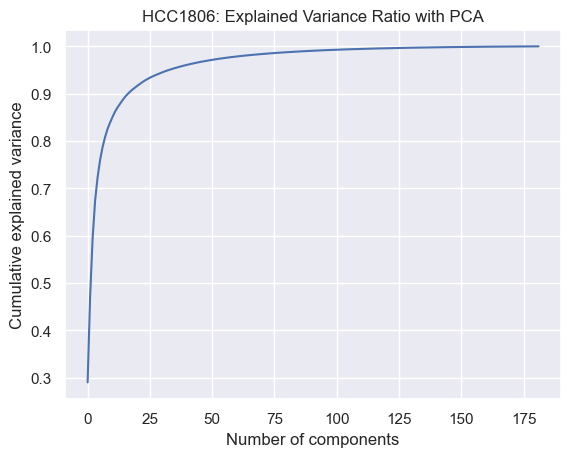

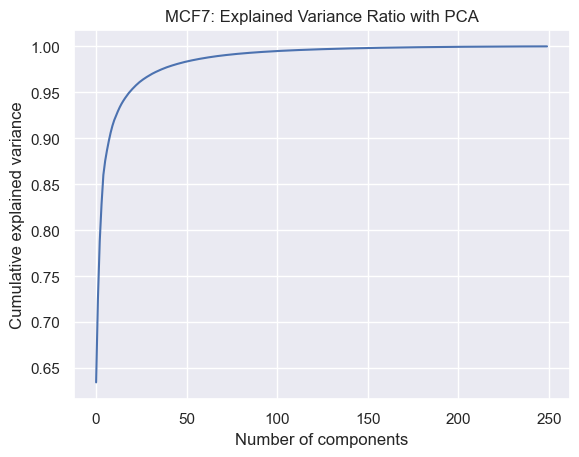

In [19]:
# Plot Explained Variance Ratio with PCA
plot_pca_ev(X_HCC, 'HCC1806')
plot_pca_ev(X_MCF, 'MCF7')

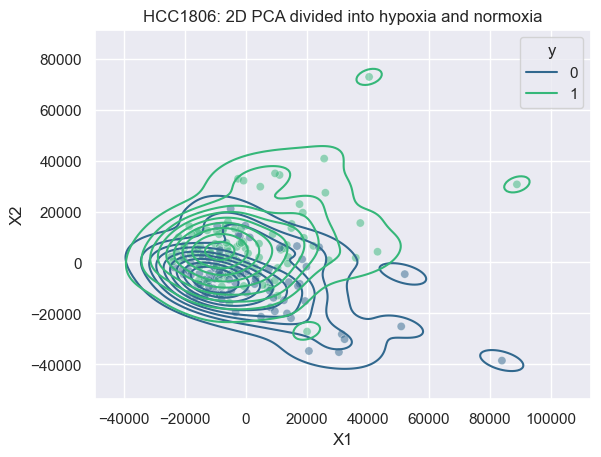

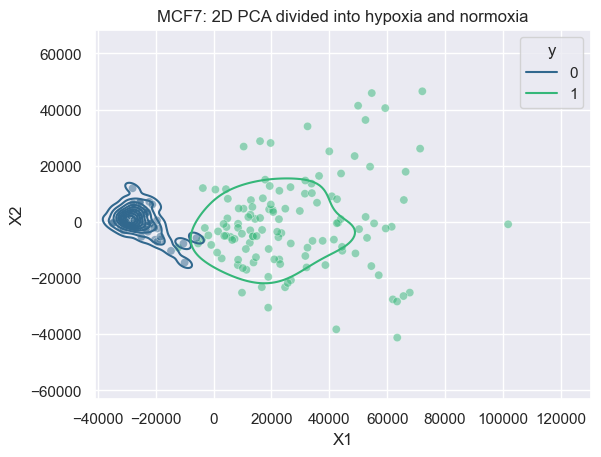

In [20]:
# Plot 2D PCA divided into hypoxia and normoxia
X_HCC_pca = pd.DataFrame(PCA(n_components=2).fit_transform(X_HCC), columns=['X1', 'X2'])
plot_2d(X_HCC_pca, y_HCC, 'HCC1806', 'PCA')

X_MCF_pca = pd.DataFrame(PCA(n_components=2).fit_transform(X_MCF), columns=['X1', 'X2'])
plot_2d(X_MCF_pca, y_MCF, 'MCF7', 'PCA')

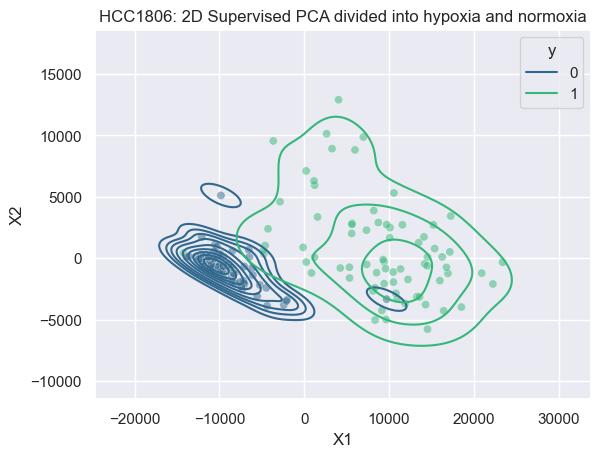

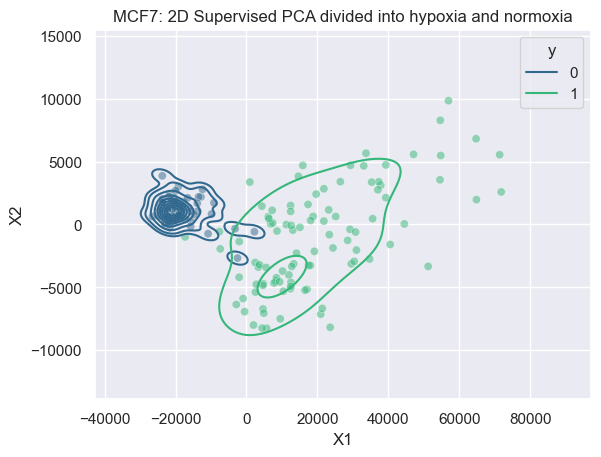

In [21]:
X_HCC_pca_supervised, HCC_pca = supervised_pca(X_HCC_tr, y_HCC_tr)
plot_2d(X_HCC_pca_supervised, y_HCC_tr, 'HCC1806', 'Supervised PCA')

X_MCF_pca_supervised, MCF_pca = supervised_pca(X_MCF_tr, y_MCF_tr)
plot_2d(X_MCF_pca_supervised, y_MCF_tr, 'MCF7', 'Supervised PCA')

In [22]:
y_HCC_pca = dim_red_predictor(X_HCC_pca_supervised[['X1', 'X2']], y_HCC_tr, X_HCC_ts, HCC_pca)
y_MCF_pca = dim_red_predictor(X_MCF_pca_supervised[['X1', 'X2']], y_MCF_tr, X_MCF_ts, MCF_pca)

print("Accuracy of HCC1806 PCA: ", accuracy_score(y_HCC_ts, y_HCC_pca))
print("Accuracy of MCF7 PCA: ", accuracy_score(y_MCF_ts, y_MCF_pca))

Accuracy of HCC1806 PCA:  1.0
Accuracy of MCF7 PCA:  0.98


### t-SNE Dimensionality Reduction

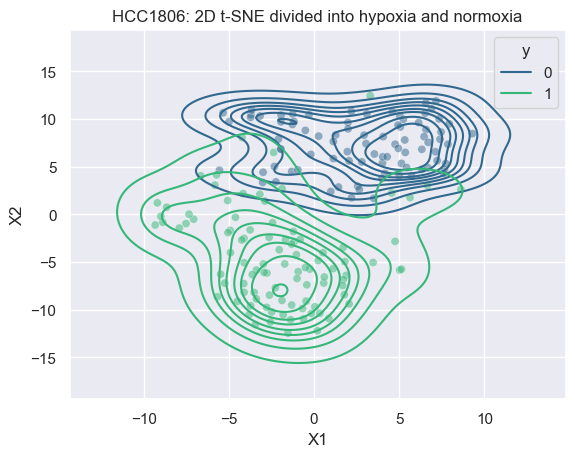

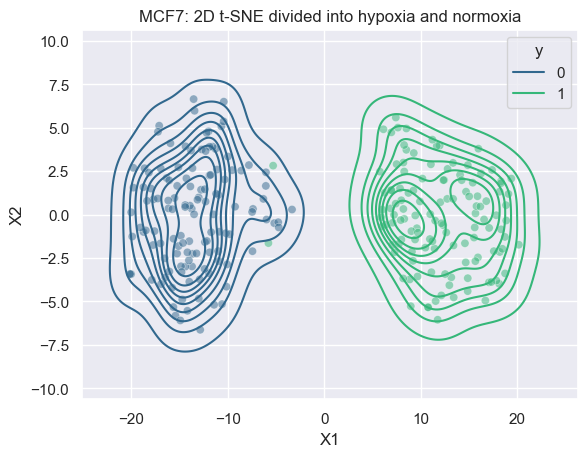

In [23]:
X_HCC_tsne = pd.DataFrame(TSNE().fit(X_HCC).transform(X_HCC), columns=['X1', 'X2'])
plot_2d(X_HCC_tsne, y_HCC, 'HCC1806', 't-SNE')

X_MCF_tsne = pd.DataFrame(TSNE().fit(X_MCF).transform(X_MCF), columns=['X1', 'X2'])
plot_2d(X_MCF_tsne, y_MCF, 'MCF7', 't-SNE')

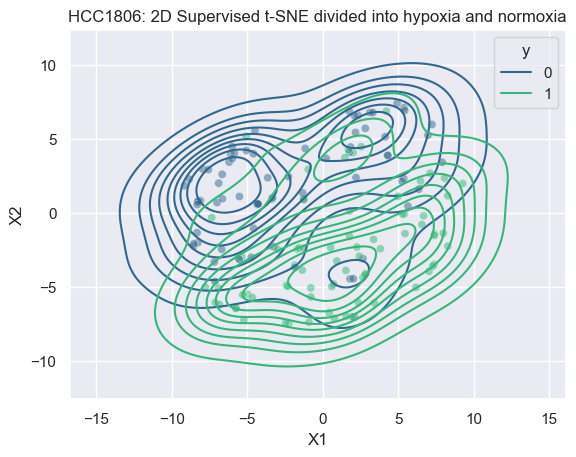

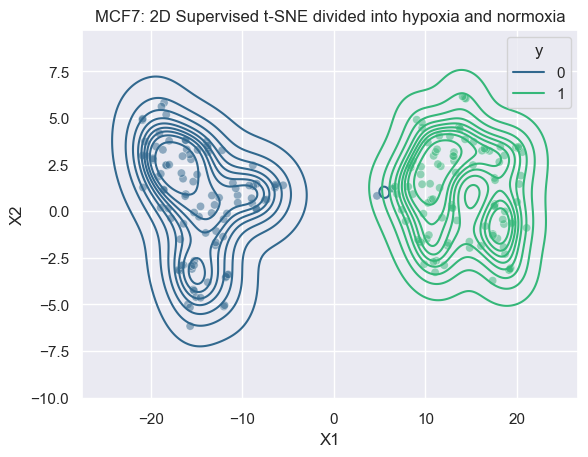

In [24]:
X_HCC_tsne_supervised, HCC_tsne = supervised_tsne(X_HCC_tr, y_HCC_tr)
plot_2d(X_HCC_tsne_supervised, y_HCC_tr, 'HCC1806', 'Supervised t-SNE')

X_MCF_tsne_supervised, MCF_tsne = supervised_tsne(X_MCF_tr, y_MCF_tr)
plot_2d(X_MCF_tsne_supervised, y_MCF_tr, 'MCF7', 'Supervised t-SNE')

In [25]:
y_HCC_tsne = dim_red_predictor(X_HCC_tsne_supervised[['X1', 'X2']], y_HCC_tr, X_HCC_ts, HCC_tsne)
y_MCF_tsne = dim_red_predictor(X_MCF_tsne_supervised[['X1', 'X2']], y_MCF_tr, X_MCF_ts, MCF_tsne)

print("Accuracy of HCC1806 t-SNE: ", accuracy_score(y_HCC_ts, y_HCC_tsne))
print("Accuracy of MCF7 t-SNE: ", accuracy_score(y_MCF_ts, y_MCF_tsne))

Accuracy of HCC1806 t-SNE:  0.7027027027027027
Accuracy of MCF7 t-SNE:  0.98


### UMAP Dimensionality Reduction

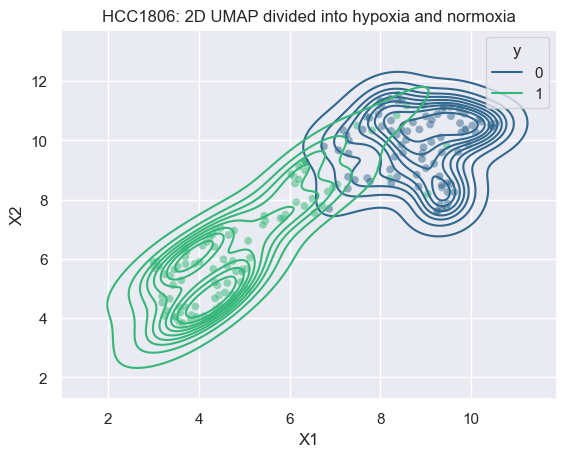

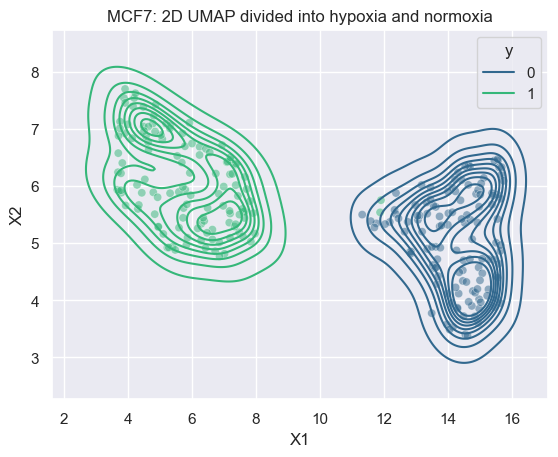

In [26]:
# Plot 2D UMAP divided into hypoxia and normoxia
X_HCC_umap = pd.DataFrame(UMAP(n_components=2).fit_transform(X_HCC), columns=['X1', 'X2'])
plot_2d(X_HCC_umap, y_HCC, 'HCC1806', 'UMAP')

X_MCF_umap = pd.DataFrame(UMAP(n_components=2).fit_transform(X_MCF), columns=['X1', 'X2'])
plot_2d(X_MCF_umap, y_MCF, 'MCF7', 'UMAP')

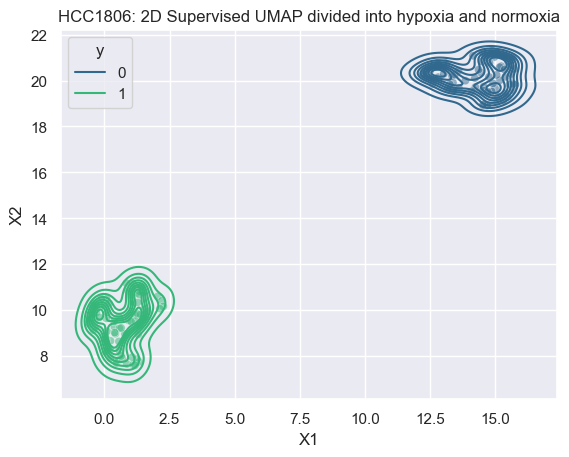

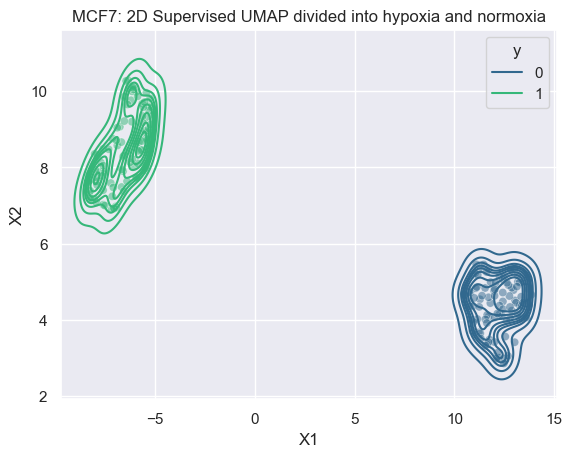

In [27]:
X_HCC_umap_supervised, HCC_umap = supervised_umap(X_HCC_tr, y_HCC_tr)
plot_2d(X_HCC_umap_supervised, y_HCC_tr, 'HCC1806', 'Supervised UMAP')

X_MCF_umap_supervised, MCF_umap = supervised_umap(X_MCF_tr, y_MCF_tr)
plot_2d(X_MCF_umap_supervised, y_MCF_tr, 'MCF7', 'Supervised UMAP')

In [28]:
y_HCC_umap = dim_red_predictor(X_HCC_umap_supervised[['X1', 'X2']], y_HCC_tr, X_HCC_ts, HCC_umap)
y_MCF_umap = dim_red_predictor(X_MCF_umap_supervised[['X1', 'X2']], y_MCF_tr, X_MCF_ts, MCF_umap)

print("Accuracy of HCC1806 UMAP: ", accuracy_score(y_HCC_ts, y_HCC_umap))
print("Accuracy of MCF7 UMAP: ", accuracy_score(y_MCF_ts, y_MCF_umap))

Accuracy of HCC1806 UMAP:  0.9459459459459459
Accuracy of MCF7 UMAP:  0.98


---
## Clustering

### K-Means

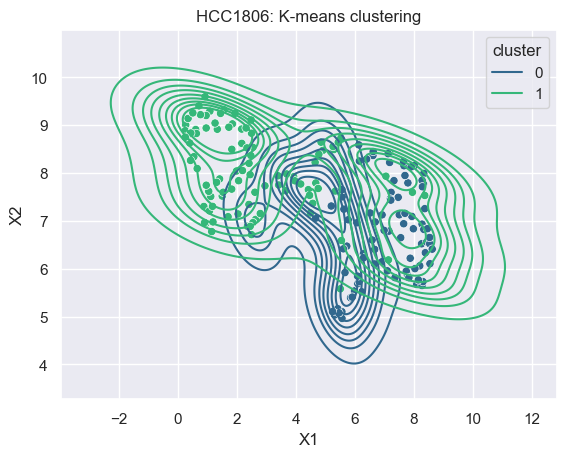

Silhouette Score: 0.249
Accuracy: 0.516


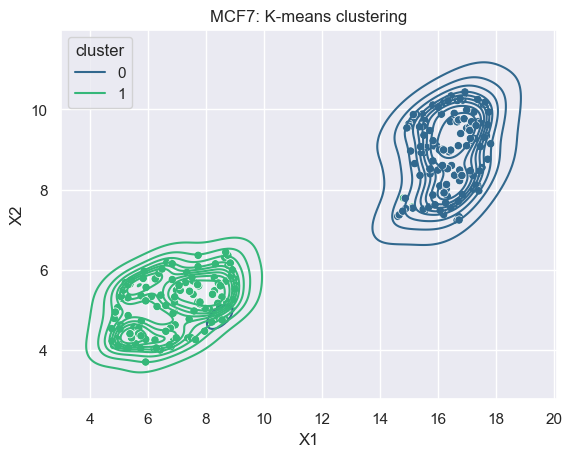

Silhouette Score: 0.466
Accuracy: 0.972


In [29]:
# Implement K-means clustering on full dimensional data
kmeans_HCC = KMeans(n_clusters=2, random_state=1).fit(X_HCC)
kmeans_HCC_score = clustering_plot(X_HCC, y_HCC, kmeans_HCC.labels_, 'HCC1806: K-means clustering')

kmeans_MCF = KMeans(n_clusters=2, random_state=42).fit(X_MCF)
kmeans_MCF_score = clustering_plot(X_MCF, y_MCF, kmeans_MCF.labels_, 'MCF7: K-means clustering')

### Gaussian Mixture Model

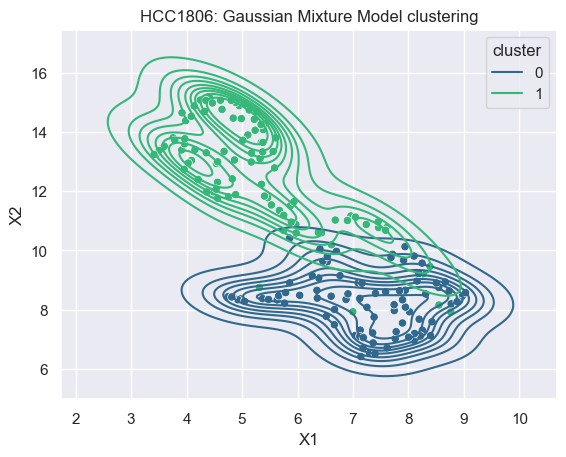

Silhouette Score: 0.144
Accuracy: 0.951


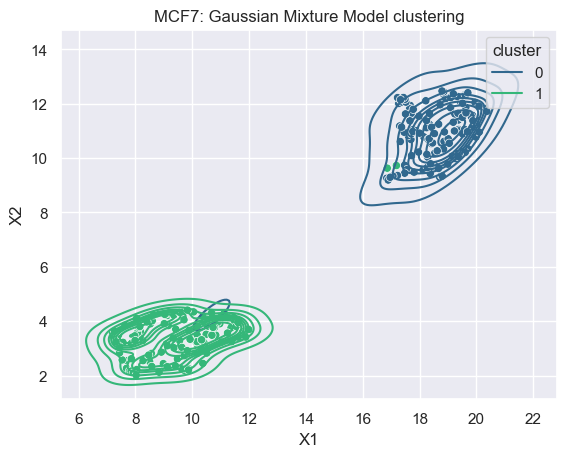

Silhouette Score: 0.466
Accuracy: 0.968


In [30]:
# Implement Gaussian Mixture Model clustering on full dimensional data
gmm_HCC = GaussianMixture(n_components=2, random_state=1).fit(X_HCC)
gmm_HCC_score = clustering_plot(X_HCC, y_HCC, gmm_HCC.predict(X_HCC), 'HCC1806: Gaussian Mixture Model clustering')

gmm_MCF = GaussianMixture(n_components=2).fit(X_MCF)
gmm_MCF_score = clustering_plot(X_MCF, y_MCF, gmm_MCF.predict(X_MCF), 'MCF7: Gaussian Mixture Model clustering')

### DBSCAN

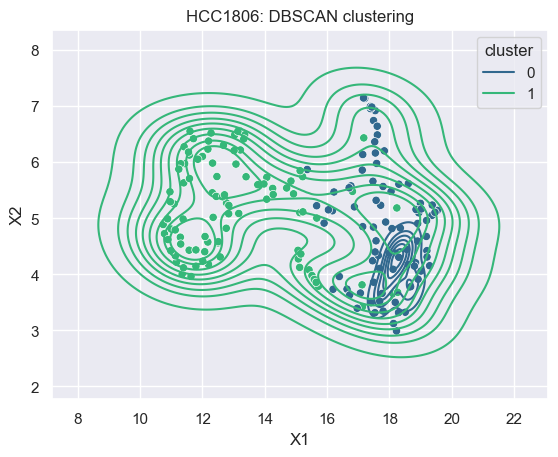

Silhouette Score: -0.152
Accuracy: 0.560


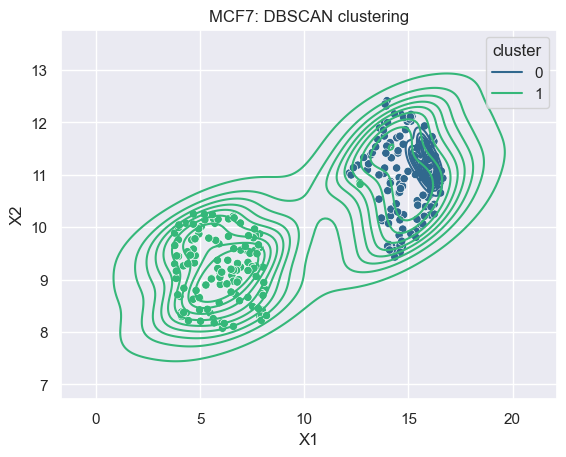

Silhouette Score: -0.247
Accuracy: 0.520


In [31]:
# Implement DBSCAN clustering on full dimensional data
dbscan_HCC = dbscan_labels(X_HCC)
dbscan_HCC_score = clustering_plot(X_HCC, y_HCC, dbscan_HCC, 'HCC1806: DBSCAN clustering')

dbscan_MCF = dbscan_labels(X_MCF)
dbscan_MCF_score = clustering_plot(X_MCF, y_MCF, dbscan_MCF, 'MCF7: DBSCAN clustering')

### Spectral Clustering

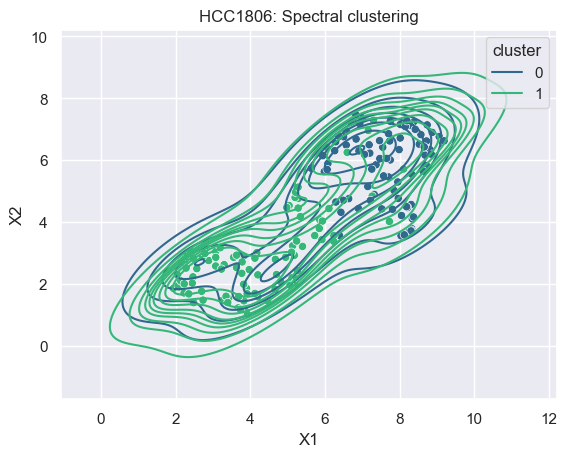

Silhouette Score: -0.008
Accuracy: 0.516


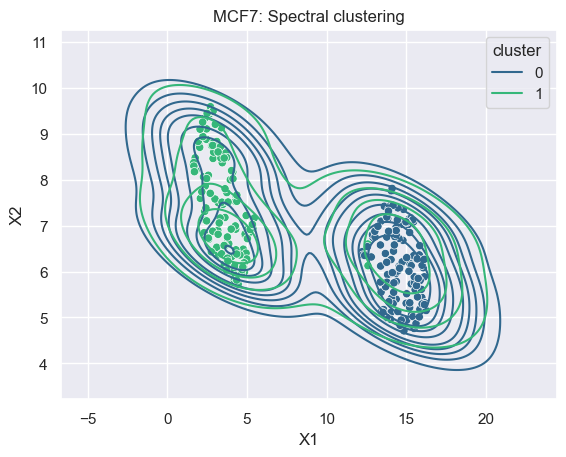

Silhouette Score: -0.005
Accuracy: 0.508


In [32]:
# Implement Spectral clustering on full dimensional data
spectral_HCC = SpectralClustering(n_clusters=2, random_state=1).fit(X_HCC)
spectral_HCC_score = clustering_plot(X_HCC, y_HCC, spectral_HCC.labels_, 'HCC1806: Spectral clustering')

spectral_MCF = SpectralClustering(n_clusters=2, random_state=42).fit(X_MCF)
spectral_MCF_score = clustering_plot(X_MCF, y_MCF, spectral_MCF.labels_, 'MCF7: Spectral clustering')

---
## Logistic Regression

In [33]:
# Train logistic regression on full dimensional data
y_HCC_lr = logistic_regression(X_HCC_tr, y_HCC_tr, X_HCC_ts)
y_MCF_lr = logistic_regression(X_MCF_tr, y_MCF_tr, X_MCF_ts)

print("Accuracy of HCC1806 Logistic Regression: ", accuracy_score(y_HCC_ts, y_HCC_lr))
print("Accuracy of MCF7 Logistic Regression: ", accuracy_score(y_MCF_ts, y_MCF_lr))

Accuracy of HCC1806 Logistic Regression:  1.0
Accuracy of MCF7 Logistic Regression:  1.0


---
## Support Vector Machines

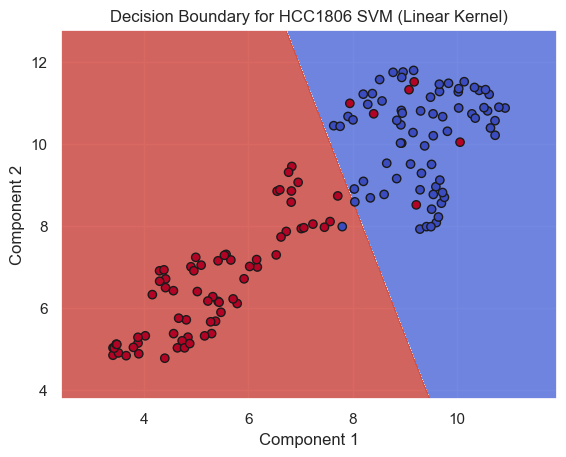

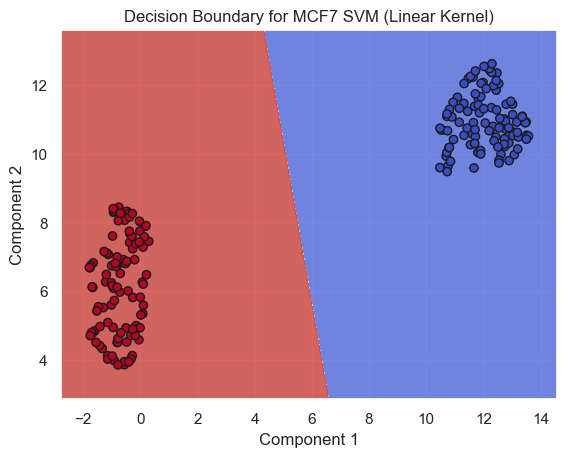

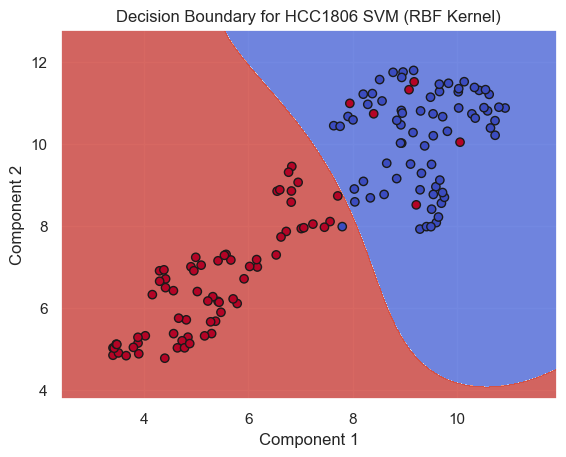

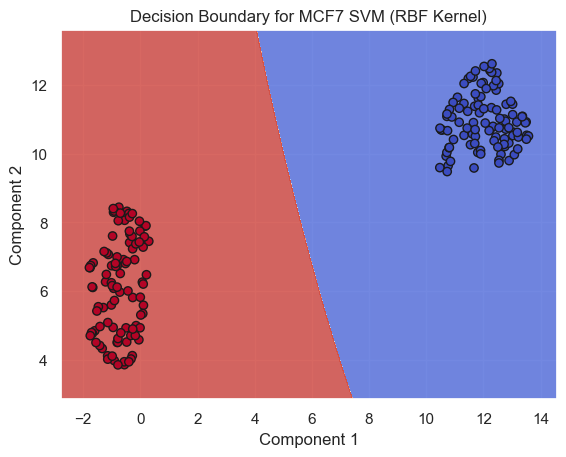

In [34]:
umap = UMAP(n_components=2, random_state=42)
X_HCC_tr_2d = umap.fit_transform(X_HCC_tr)
X_HCC_ts_2d = umap.fit_transform(X_HCC_ts)
X_MCF_tr_2d = umap.fit_transform(X_MCF_tr)
X_MCF_ts_2d = umap.fit_transform(X_MCF_ts)

y_HCC_svm, HCC_svm_lin = svm(X_HCC_tr_2d, y_HCC_tr, X_HCC_ts_2d)
y_MCF_svm, MCF_svm_lin = svm(X_MCF_tr_2d, y_MCF_tr, X_MCF_ts_2d)

plot_decision_boundary(X_HCC_tr_2d, y_HCC_tr, HCC_svm_lin, 'Decision Boundary for HCC1806 SVM (Linear Kernel)')
plot_decision_boundary(X_MCF_tr_2d, y_MCF_tr, MCF_svm_lin, 'Decision Boundary for MCF7 SVM (Linear Kernel)')

y_HCC_svm_rbf, HCC_svm_rbf = svm(X_HCC_tr_2d, y_HCC_tr, X_HCC_ts_2d, kernel='rbf')
y_MCF_svm_rbf, MCF_svm_rbf = svm(X_MCF_tr_2d, y_MCF_tr, X_MCF_ts_2d, kernel='rbf')

plot_decision_boundary(X_HCC_tr_2d, y_HCC_tr, HCC_svm_rbf, 'Decision Boundary for HCC1806 SVM (RBF Kernel)')
plot_decision_boundary(X_MCF_tr_2d, y_MCF_tr, MCF_svm_rbf, 'Decision Boundary for MCF7 SVM (RBF Kernel)')

In [35]:
y_HCC_svm, HCC_svm_lin = svm(X_HCC_tr, y_HCC_tr, X_HCC_ts)
y_MCF_svm, MCF_svm_lin = svm(X_MCF_tr, y_MCF_tr, X_MCF_ts)

print("Accuracy of HCC1806 SVM: ", accuracy_score(y_HCC_ts, y_HCC_svm))
print("Accuracy of MCF7 SVM: ", accuracy_score(y_MCF_ts, y_MCF_svm))

y_HCC_svm_rbf, HCC_svm_rbf = svm(X_HCC_tr, y_HCC_tr, X_HCC_ts, kernel='rbf')
y_MCF_svm_rbf, MCF_svm_rbf = svm(X_MCF_tr, y_MCF_tr, X_MCF_ts, kernel='rbf')

print("Accuracy of HCC1806 SVM with RBF kernel: ", accuracy_score(y_HCC_ts, y_HCC_svm_rbf))
print("Accuracy of MCF7 SVM with RBF kernel: ", accuracy_score(y_MCF_ts, y_MCF_svm_rbf))

Accuracy of HCC1806 SVM:  1.0
Accuracy of MCF7 SVM:  0.96
Accuracy of HCC1806 SVM with RBF kernel:  1.0
Accuracy of MCF7 SVM with RBF kernel:  0.98


---
## Random Forest

In [36]:
# Random Forest on full dimensional data
y_HCC_rf = random_forest(X_HCC_tr, y_HCC_tr, X_HCC_ts)
y_MCF_rf = random_forest(X_MCF_tr, y_MCF_tr, X_MCF_ts)

print("Accuracy of HCC1806 Random Forest: ", accuracy_score(y_HCC_ts, y_HCC_rf))
print("Accuracy of MCF7 Random Forest: ", accuracy_score(y_MCF_ts, y_MCF_rf))

Accuracy of HCC1806 Random Forest:  1.0
Accuracy of MCF7 Random Forest:  0.98


---
## MLP

In [37]:
#  Train a neural network on full dimensional data
y_HCC_nn = neural_network(X_HCC_tr, y_HCC_tr, X_HCC_ts)
y_MCF_nn = neural_network(X_MCF_tr, y_MCF_tr, X_MCF_ts)

print("Accuracy of HCC1806 Neural Network: ", accuracy_score(y_HCC_ts, y_HCC_nn))
print("Accuracy of MCF7 Neural Network: ", accuracy_score(y_MCF_ts, y_MCF_nn))

Accuracy of HCC1806 Neural Network:  0.9459459459459459
Accuracy of MCF7 Neural Network:  1.0


---
## Results

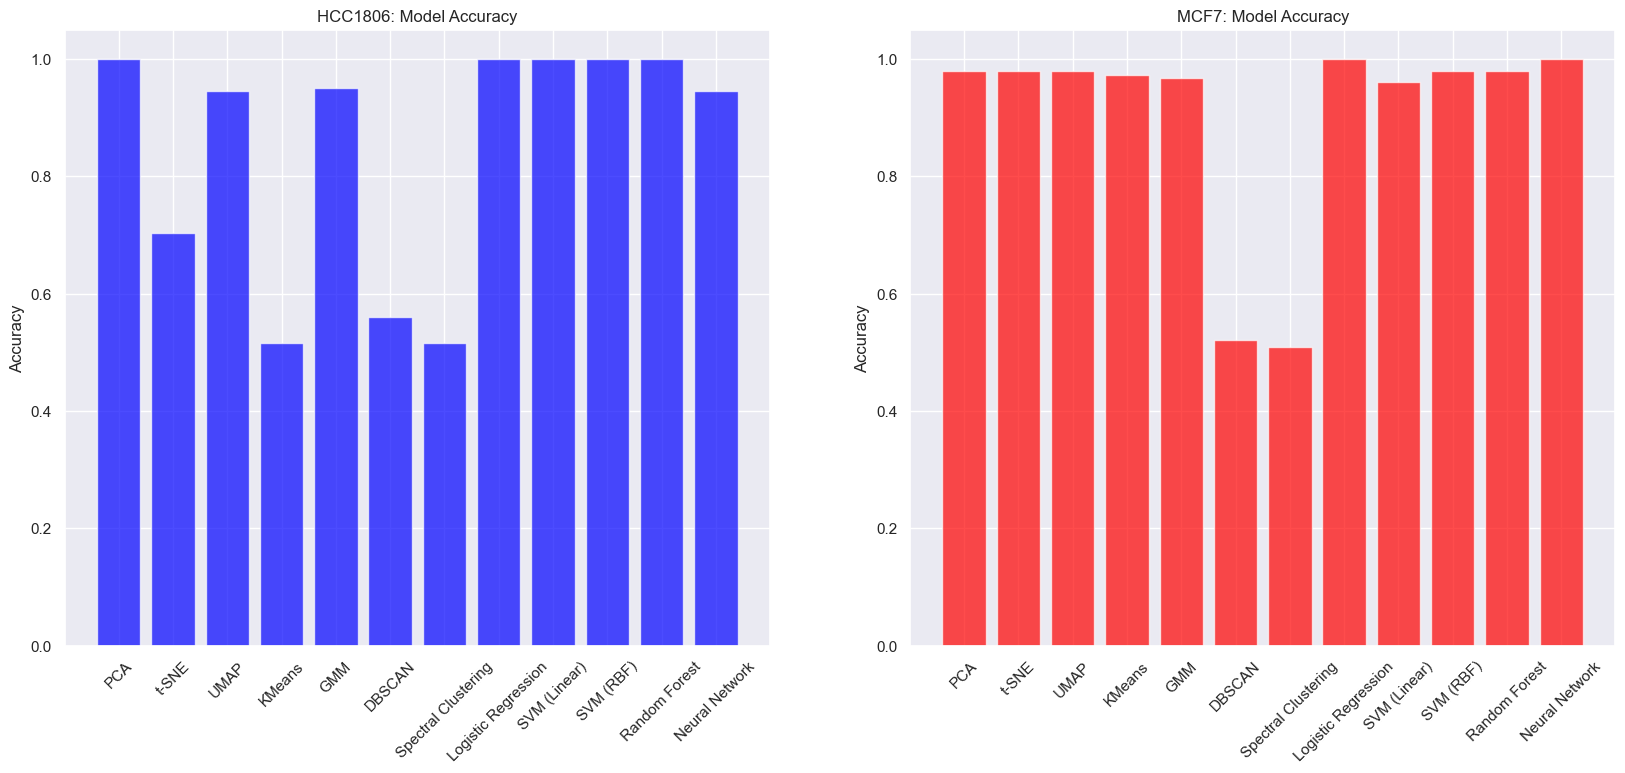

In [ ]:
spca_HCC_score =accuracy_score(y_HCC_ts, y_HCC_pca)
stsne_HCC_score = accuracy_score(y_HCC_ts, y_HCC_tsne)
sumap_HCC_score = accuracy_score(y_HCC_ts, y_HCC_umap)

spca_MCF_score = accuracy_score(y_MCF_ts, y_MCF_pca)
stsne_MCF_score = accuracy_score(y_MCF_ts, y_MCF_tsne)
sumap_MCF_score = accuracy_score(y_MCF_ts, y_MCF_umap)

lr_HCC_score = accuracy_score(y_HCC_ts, y_HCC_lr)
lr_MCF_score = accuracy_score(y_MCF_ts, y_MCF_lr)

svm_HCC_lin_score = accuracy_score(y_HCC_ts, y_HCC_svm)
svm_MCF_lin_score = accuracy_score(y_MCF_ts, y_MCF_svm)

svm_HCC_rbf_score = accuracy_score(y_HCC_ts, y_HCC_svm_rbf)
svm_MCF_rbf_score = accuracy_score(y_MCF_ts, y_MCF_svm_rbf)

rf_HCC_score = accuracy_score(y_HCC_ts, y_HCC_rf)
rf_MCF_score = accuracy_score(y_MCF_ts, y_MCF_rf)

nn_HCC_score = accuracy_score(y_HCC_ts, y_HCC_nn)
nn_MCF_score = accuracy_score(y_MCF_ts, y_MCF_nn)

plot_models(spca_HCC_score, stsne_HCC_score, sumap_HCC_score, kmeans_HCC_score, gmm_HCC_score, 
            dbscan_HCC_score, spectral_HCC_score, lr_HCC_score, svm_HCC_lin_score, svm_HCC_rbf_score, 
            rf_HCC_score, nn_HCC_score, spca_MCF_score, stsne_MCF_score, sumap_MCF_score, 
            kmeans_MCF_score, gmm_MCF_score, dbscan_MCF_score, spectral_MCF_score, lr_MCF_score, 
            svm_MCF_lin_score, svm_MCF_rbf_score, rf_MCF_score, nn_MCF_score)

In [41]:
del X_HCC, X_MCF, y_HCC, y_MCF, X_HCC_tr, X_HCC_ts, y_HCC_tr, y_HCC_ts, X_MCF_tr, X_MCF_ts, y_MCF_tr, y_MCF_ts